--- 1. Processing Data ---


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_41493/327535033.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)


Dropped 20 rows due to NaN (Rolling Windows). Final Length: 1489
Training Data Shape: (1489, 6)
--- 2. Setting up Environment ---
--- 3. Initializing Transformer-PPO Agent ---
Using cpu device
--- 4. Training Agent ---
-----------------------------
| time/              |      |
|    fps             | 1276 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 350           |
|    iterations           | 2             |
|    time_elapsed         | 11            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00087104173 |
|    clip_fraction        | 0.00972       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | -0.239        |
|    learning_rate        | 0.0003        |

/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_41493/327535033.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)


Dropped 20 rows due to NaN (Rolling Windows). Final Length: 232


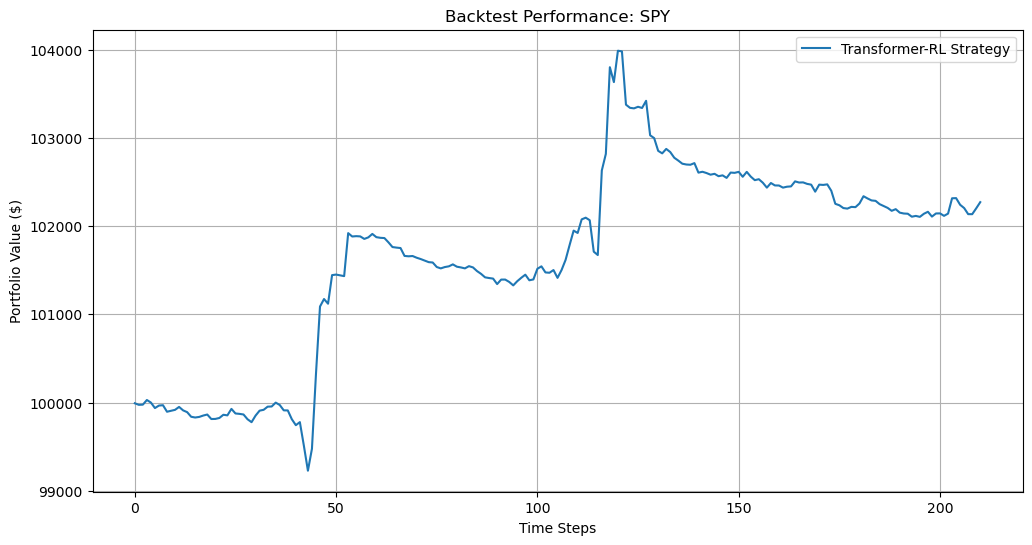

Final Portfolio Value: $102272.98


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from collections import deque
import sys

# ==========================================
# 1. HYPERPARAMETERS & CONFIGURATION
# ==========================================
# Adjustable parameters for the strategy
CONFIG = {
    # Data Settings
    "TICKERS": ["SPY", "QQQ", "GLD", "^VIX"],  # Portfolio assets + Macro (VIX)
    "TARGET_ASSET": "SPY",                     # The asset to trade
    "START_DATE": "2018-01-01",
    "END_DATE": "2024-01-01",
    "TEST_START_DATE": "2024-01-02",
    
    # Feature Engineering
    "WINDOW_SIZE": 20,         # Lookback window (Transformer context length)
    "TECHNICAL_INDICATORS": True,
    
    # RL Environment Settings
    "INITIAL_BALANCE": 100000,
    "TRADING_FEES": 0.001,     # 0.1% per trade
    "MAX_LEVERAGE": 1.0,       # 1.0 = No leverage, >1.0 = Leverage
    
    # Reward Shaping (The "Mathematical Idea")
    "REWARD_METHOD": "differential_sharpe", # Options: 'pnl', 'differential_sharpe', 'sortino'
    "RISK_AVERSION": 0.1,      # Penalty factor for volatility (if using PnL-Risk)
    
    # Transformer Architecture (The "Data Science Idea")
    "D_MODEL": 64,             # Embedding dimension
    "N_HEAD": 4,               # Number of attention heads
    "N_LAYERS": 2,             # Number of transformer encoder layers
    "DROPOUT": 0.1,
    
    # PPO Agent Settings
    "LEARNING_RATE": 3e-4,
    "N_STEPS": 2048,
    "BATCH_SIZE": 64,
    "ENTROPY_COEF": 0.01,      # Encourages exploration (Docs: "High Alpha")
    "TRAINING_TIMESTEPS": 50000
}

# ==========================================
# 2. DATA PIPELINE
# ==========================================
class DataProcessor:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        
    def download_data(self):
        print(f"Downloading data for {self.tickers}...")
        try:
            # yfinance download
            data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
            
            if data.empty:
                print("Error: yfinance returned empty data.")
                return pd.DataFrame()

            # Handle MultiIndex column issue in new yfinance versions
            # Structure is typically (Price Type, Ticker) or just (Price Type) if single ticker
            if isinstance(data.columns, pd.MultiIndex):
                # Check if 'Close' is in the top level
                if 'Close' in data.columns.levels[0]:
                    data = data.xs('Close', level=0, axis=1)
                # Check if 'Close' is in the second level (rare but possible)
                elif 'Close' in data.columns.levels[1]:
                    data = data.xs('Close', level=1, axis=1)
                else:
                    # Fallback: try 'Adj Close'
                    if 'Adj Close' in data.columns.levels[0]:
                        data = data.xs('Adj Close', level=0, axis=1)
            
            # If data is still multi-dimensional but we expected a flat frame for single ticker requests
            if isinstance(data, pd.Series):
                data = data.to_frame()
                
            return data
            
        except Exception as e:
            print(f"Error during download: {e}")
            return pd.DataFrame()

    def add_technical_indicators(self, df, target_ticker):
        """
        Adds RSI, MACD, and Volatility to the dataframe.
        """
        if df.empty:
            return df
            
        if target_ticker not in df.columns:
            print(f"Error: Target ticker {target_ticker} not found in downloaded data columns: {df.columns}")
            return pd.DataFrame()

        # Calculate Returns
        df = df.copy() # Avoid SettingWithCopyWarning
        df['returns'] = df[target_ticker].pct_change()
        
        # 1. Relative Strength Index (RSI)
        delta = df[target_ticker].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # 2. MACD
        exp1 = df[target_ticker].ewm(span=12, adjust=False).mean()
        exp2 = df[target_ticker].ewm(span=26, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
        
        # 3. Rolling Volatility (Risk Proxy)
        df['volatility'] = df['returns'].rolling(window=20).std()
        
        # 4. Rolling Z-Score (Normalization for Stationarity - Doc 2)
        window = 20
        rolling_mean = df[target_ticker].rolling(window=window).mean()
        rolling_std = df[target_ticker].rolling(window=window).std()
        df['z_score'] = (df[target_ticker] - rolling_mean) / (rolling_std + 1e-8)
        
        # Drop NaNs created by rolling windows
        original_len = len(df)
        df.dropna(inplace=True)
        print(f"Dropped {original_len - len(df)} rows due to NaN (Rolling Windows). Final Length: {len(df)}")
        
        return df

    def get_processed_data(self, target_ticker):
        df = self.download_data()
        
        if df.empty:
            print("No data downloaded.")
            return pd.DataFrame()
            
        df = self.add_technical_indicators(df, target_ticker)
        
        if df.empty:
            print("Dataframe is empty after adding indicators (all rows dropped).")
            return pd.DataFrame()
        
        # Select features: Returns, Z-Score, RSI, MACD, Volatility, VIX (if present)
        features = ['returns', 'z_score', 'rsi', 'macd', 'volatility']
        if '^VIX' in df.columns:
            # Normalize VIX
            df['vix_norm'] = (df['^VIX'] - df['^VIX'].rolling(50).mean()) / df['^VIX'].rolling(50).std()
            # Since VIX rolling might introduce new NaNs at the start that weren't dropped yet
            df['vix_norm'] = df['vix_norm'].fillna(0) 
            features.append('vix_norm')
            
        final_df = df[features].fillna(0) # Ensure no NaNs
        return final_df

# ==========================================
# 3. CUSTOM GYM ENVIRONMENT
# ==========================================
class TransformerTradingEnv(gym.Env):
    """
    A trading environment that mimics the OpenAI Gym structure.
    State: Rolling window of market features (Window_Size x Num_Features).
    Action: Continuous value [-1, 1] representing portfolio weight.
    Reward: Differential Sharpe Ratio (DSR) or Risk-Adjusted PnL.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, df, config):
        super(TransformerTradingEnv, self).__init__()
        
        # VALIDATION
        if df is None or df.empty:
            raise ValueError("Environment received empty DataFrame. Cannot initialize.")
        if len(df) <= config['WINDOW_SIZE'] + 1:
            raise ValueError(f"Data length ({len(df)}) must be greater than WINDOW_SIZE ({config['WINDOW_SIZE']}).")

        self.df = df
        self.config = config
        self.window_size = config['WINDOW_SIZE']
        self.n_features = df.shape[1]
        
        # Define Action and Observation Spaces
        # Action: [-1, 1] -> -100% Short to +100% Long
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        
        # Observation: (Window_Size, Num_Features)
        # This 2D structure is required for the Transformer to understand temporal sequence
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.window_size, self.n_features), 
            dtype=np.float32
        )
        
        # State variables
        self.current_step = self.window_size
        self.balance = config['INITIAL_BALANCE']
        self.position = 0 # Current position (units of asset)
        self.portfolio_value = self.balance
        self.history = []
        
        # Differential Sharpe Ratio variables (Online updating)
        self.A_t = 0 # Moving average of returns
        self.B_t = 0 # Moving average of squared returns
        self.eta = 0.05 # Decay rate for DSR moving average

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.config['INITIAL_BALANCE']
        self.position = 0
        self.portfolio_value = self.balance
        self.A_t = 0
        self.B_t = 0
        self.history = []
        return self._get_observation(), {}

    def _get_observation(self):
        # Return the last 'window_size' rows
        # Ensure we don't go out of bounds
        start_idx = self.current_step - self.window_size
        end_idx = self.current_step
        
        obs = self.df.iloc[start_idx : end_idx].values
        return obs.astype(np.float32)

    def _calculate_differential_sharpe(self, returns):
        """
        Implements the Differential Sharpe Ratio (DSR) from Doc 2.
        D_t = (B_{t-1} * Delta_A_t - 0.5 * A_{t-1} * Delta_B_t) / (B_{t-1} - A_{t-1}^2)^(3/2)
        """
        if self.current_step < self.window_size + 2:
            return 0 # Not enough history

        # Update Moving Averages
        delta_A = returns - self.A_t
        delta_B = (returns ** 2) - self.B_t
        
        prev_A = self.A_t
        prev_B = self.B_t
        
        self.A_t += self.eta * delta_A
        self.B_t += self.eta * delta_B
        
        # Calculate DSR
        denominator = (prev_B - prev_A**2) ** 1.5
        if denominator < 1e-6: # Avoid division by zero
            return 0
            
        dsr = (prev_B * delta_A - 0.5 * prev_A * delta_B) / denominator
        return dsr * 0.1 # Scale reward for stability

    def step(self, action):
        # 1. Execute Trade
        # In a real sim, we would track actual price. 
        # Here, we simplify to return-based logic.
        
        action = np.clip(action, -1, 1)[0]
        
        # Calculate PnL based on previous action's exposure to current step's return
        # df['returns'] is at index `current_step` (return from t-1 to t)
        if self.current_step >= len(self.df):
            # This shouldn't happen if terminated logic is correct, but safe guard
            return self._get_observation(), 0, True, False, {'portfolio_value': self.portfolio_value}
            
        market_return = self.df.iloc[self.current_step]['returns']
        
        # Transaction Cost (Penalty for changing position)
        prev_action = self.history[-1]['action'] if len(self.history) > 0 else 0
        turnover = abs(action - prev_action)
        cost = turnover * self.config['TRADING_FEES']
        
        # Portfolio Return = Strategy Return - Cost
        strategy_return = (action * market_return) - cost
        
        self.portfolio_value *= (1 + strategy_return)
        
        # 2. Calculate Reward
        reward = 0
        if self.config['REWARD_METHOD'] == 'differential_sharpe':
            reward = self._calculate_differential_sharpe(strategy_return)
        else:
            # Fallback: Risk-Adjusted PnL
            reward = strategy_return - self.config['RISK_AVERSION'] * abs(strategy_return)

        # 3. Advance State
        self.current_step += 1
        
        # Terminate if we reach end of data
        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        
        # 4. Logging
        info = {
            'portfolio_value': self.portfolio_value,
            'return': strategy_return,
            'action': action
        }
        self.history.append(info)
        
        return self._get_observation(), reward, terminated, truncated, info

# ==========================================
# 4. TRANSFORMER FEATURE EXTRACTOR
# ==========================================
class TransformerExtractor(BaseFeaturesExtractor):
    """
    Custom Feature Extractor using a Transformer Encoder.
    This replaces the default MLP/CNN in Stable Baselines 3.
    """
    def __init__(self, observation_space: spaces.Box, features_dim: int = 64):
        super(TransformerExtractor, self).__init__(observation_space, features_dim)
        
        n_input_features = observation_space.shape[1] # Number of columns (RSI, Returns, etc.)
        self.window_size = observation_space.shape[0] # Time window
        
        # Linear projection to d_model
        self.embedding = nn.Linear(n_input_features, CONFIG['D_MODEL'])
        
        # Positional Encoding (Learnable)
        self.position_embedding = nn.Parameter(torch.randn(1, self.window_size, CONFIG['D_MODEL']))
        
        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=CONFIG['D_MODEL'],
            nhead=CONFIG['N_HEAD'],
            dim_feedforward=128,
            dropout=CONFIG['DROPOUT'],
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=CONFIG['N_LAYERS'])
        
        # Final flattening to features_dim
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(CONFIG['D_MODEL'] * self.window_size, features_dim)
        self.activation = nn.ReLU()

    def forward(self, observations):
        # Input shape: (Batch, Window, Features)
        x = self.embedding(observations) 
        
        # Add Positional Encoding
        x = x + self.position_embedding
        
        # Transformer Pass
        x = self.transformer_encoder(x)
        
        # Flatten and Project
        x = self.flatten(x)
        x = self.activation(self.linear(x))
        return x

# ==========================================
# 5. MAIN EXECUTION LOOP
# ==========================================
def run_strategy():
    print("--- 1. Processing Data ---")
    data_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['START_DATE'], CONFIG['END_DATE'])
    train_df = data_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if train_df.empty:
        print("CRITICAL ERROR: Training Data is empty. Check your tickers, dates, or internet connection.")
        return

    print(f"Training Data Shape: {train_df.shape}")
    
    print("--- 2. Setting up Environment ---")
    try:
        env = TransformerTradingEnv(train_df, CONFIG)
        env = DummyVecEnv([lambda: env]) # Vectorize for SB3
    except ValueError as e:
        print(f"Environment Init Failed: {e}")
        return
    
    print("--- 3. Initializing Transformer-PPO Agent ---")
    # We pass the custom policy definition to PPO
    policy_kwargs = dict(
        features_extractor_class=TransformerExtractor,
        features_extractor_kwargs=dict(features_dim=64),
    )
    
    model = PPO(
        "MlpPolicy", 
        env, 
        policy_kwargs=policy_kwargs, 
        learning_rate=CONFIG['LEARNING_RATE'],
        verbose=1,
        ent_coef=CONFIG['ENTROPY_COEF'] # High entropy -> Exploration (Doc 2)
    )
    
    print("--- 4. Training Agent ---")
    model.learn(total_timesteps=CONFIG['TRAINING_TIMESTEPS'])
    
    print("--- 5. Backtesting ---")
    # Load Test Data
    test_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['TEST_START_DATE'], "2025-01-01")
    test_df = test_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if test_df.empty:
        print("Test data is empty. Skipping backtest.")
        return

    if len(test_df) <= CONFIG['WINDOW_SIZE']:
        print(f"Not enough test data ({len(test_df)}) for window size ({CONFIG['WINDOW_SIZE']}). Skipping.")
        return

    try:
        test_env = TransformerTradingEnv(test_df, CONFIG)
    except ValueError as e:
        print(f"Test Environment Init Failed: {e}")
        return
    
    obs, _ = test_env.reset()
    done = False
    portfolio_values = []
    
    while not done:
        action, _states = model.predict(obs, deterministic=True) # Deterministic for evaluation
        obs, reward, done, truncated, info = test_env.step(action)
        portfolio_values.append(info['portfolio_value'])
        
    # Plot Results
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Transformer-RL Strategy')
    plt.title(f"Backtest Performance: {CONFIG['TARGET_ASSET']}")
    plt.xlabel('Time Steps')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Final Portfolio Value: ${portfolio_values[-1]:.2f}")

if __name__ == "__main__":
    # Ensure PyTorch uses efficient settings
    torch.set_num_threads(4)
    run_strategy()